In [6]:
#!pip install pandas_datareader
#!pip install linearmodels

In [7]:
import pandas as pd
import numpy as np
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
 
from linearmodels.asset_pricing import LinearFactorModel
 
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# 2000~2020 월별 수익률
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2000', end='2020-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
 5   RF      252 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


In [13]:
# 17개 산업군의 월별 포트폴리오 수익률
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2000', end='2020-12')[0]
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    252 non-null    float64
 1   Mines   252 non-null    float64
 2   Oil     252 non-null    float64
 3   Clths   252 non-null    float64
 4   Durbl   252 non-null    float64
 5   Chems   252 non-null    float64
 6   Cnsum   252 non-null    float64
 7   Cnstr   252 non-null    float64
 8   Steel   252 non-null    float64
 9   FabPr   252 non-null    float64
 10  Machn   252 non-null    float64
 11  Cars    252 non-null    float64
 12  Trans   252 non-null    float64
 13  Utils   252 non-null    float64
 14  Rtail   252 non-null    float64
 15  Finan   252 non-null    float64
 16  Other   252 non-null    float64
dtypes: float64(17)
memory usage: 35.4 KB


In [14]:
# 포트폴리오 수익률 - 무위험 수익률 = 초과 수익률
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
 
# 무위험 수익률 변수를 제외한 5개 팩터 변수만 남김
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

# 무위험 수익률, 기업이익, 투자수준 변수를 제외한 3개 팩터 변수만 남김
ff_factor_data_3 = ff_factor_data.drop('RMW', axis=1)
ff_factor_data_3 = ff_factor_data_3.drop('CMA', axis=1)
ff_factor_data_3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
dtypes: float64(3)
memory usage: 7.9 KB


In [16]:
# Step 1: Factor Exposures
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], # 종속변수 
                exog=add_constant(ff_factor_data) # 독립변수
                ).fit()
    betas.append(step1.params.drop('const'))
    
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


In [18]:
betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Food,0.649066,-0.099160,-0.054210,0.440742,0.393435
Mines,1.102413,0.541505,-0.056852,0.457603,0.356041
Oil,1.095080,0.265846,0.312341,0.563878,0.108612
Clths,1.125886,0.284427,0.305766,0.675941,-0.169435
Durbl,1.212690,0.489880,0.127000,0.479935,0.211053


In [19]:
# Step 2: Risk Premia
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], # 종속변수
                exog=betas # 독립변수
                ).fit()
    lambdas.append(step2.params)
 
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 19.9 KB


In [20]:
lambdas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2000-01,-5.522403,18.647240,6.587611,-17.191387,30.874359
2000-02,1.718530,12.053538,-13.654845,-18.563605,-8.170504
2000-03,7.865748,-18.591428,3.493584,15.382971,-20.375556
2000-04,-2.359133,-4.862151,2.953755,4.693526,9.088537
2000-05,-3.649551,-12.936032,14.241829,2.107961,13.434190


In [21]:
lambdas.mean()

Mkt-RF    0.575914
SMB      -0.533012
HML      -0.159653
RMW       0.600983
CMA      -0.040827
dtype: float64

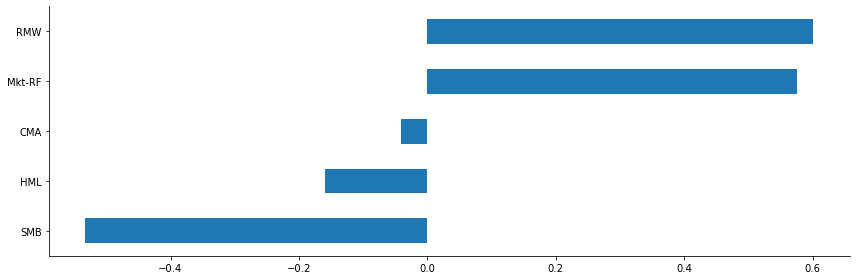

In [22]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout()

In [23]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.123776
SMB      -0.074645
HML      -0.034495
RMW       0.121432
CMA      -0.006112
dtype: float64

아래는 2단계 추정의 결과로 산출된 계수 값들을 2년 단위로 이동평균을 계산하여 그래프를 그린 것이다. 계수 추정치가 시간의 흐름에 따라 크게 변하지는 않는지 확인하기 위한 것으로 보면 된다.

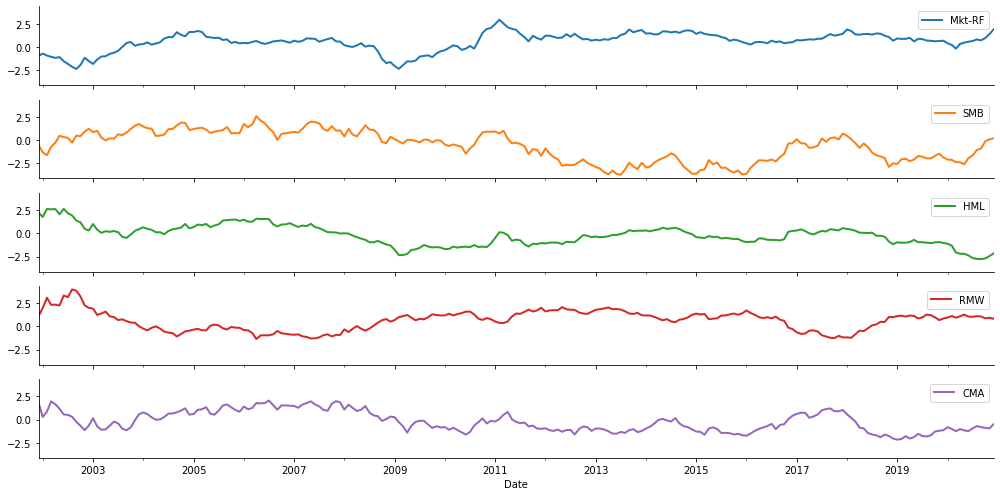

In [24]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

LinearModels 라이브러리는 statsmodels 라이브러리를 확장하여 패널 데이터를 다루기 위한 다양한 모델을 제공하고 파마-맥베스 회귀 모형도 제공한다. 위에서 2-step으로 직접구현한 결과와 동일한 계수 추정치를 얻을 수 있다.

In [25]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6827
No. Factors:                          5   J-statistic:                    12.909
No. Observations:                   252   P-value                         0.3757
Date:                  Mon, Nov 07 2022   Distribution:                 chi2(12)
Time:                          11:54:36                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5759     0.3016     1.9098     0.0562     -0.0151      1.1670
SMB           -0.5330     0.5277    

파마-맥베스의 연구에서는 시장의 초과 수익률 베타의 효과가 없고 사이즈(SMB), 가치(HML) 팩터의 효과가 있다는 것을 보여주었는데 분석 기간의 차이로 인한 것인지 2000부터 2020년까지의 데이터로 분석한 결과에서는 Mkt-RF는 유의한 팩터이고, SMB, HML은 유의하지 않은 팩터로 나타났다. Mkt-RF와 RMW만 유의한 팩터로 나타났는데, 영업이익이 꾸준하게 나오고 모멘텀이 좋은(Mkt-RF는 모멘텀 팩터로 볼 수 있다고 함) 자산에 투자하는 것이 좋다라고 해석해볼 수 있을 것 같다. 2000부터 2020년까지 어떤 주식들이 많이 올랐는지 생각해보면 어느 정도 말이 되는 것 같기도 하다. 구글, 페이스북, 애플, 마이크로소프트 등등. 이렇게 분석 기간에 따른 차이 효과를 보정하기 위해 여러 기간의 데이터를 섞어서 백테스팅을 하는 경우가 많다고 한다.

full_summary를 프린트해보면 각각의 산업군에 대한 계수 추정치가 나오는데 산업군별로 유의한 팩터들이 다르게 나타나는 것을 볼 수 있다. 팩터들 중에서 Mkt-RF만이 모든 산업군에 걸쳐 유의한 팩터로 나타났는데, 2000년대 들어서 시장 모멘텀이 자산 수익률을 설명하는데 있어서 다른 팩터에 비해 중요한 요소가 되었다고 볼 수 있을 것 같다.

In [26]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6827
No. Factors:                          5   J-statistic:                    12.909
No. Observations:                   252   P-value                         0.3757
Date:                  Mon, Nov 07 2022   Distribution:                 chi2(12)
Time:                          11:54:36                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5759     0.3016     1.9098     0.0562     -0.0151      1.1670
SMB           -0.5330     0.5277    